In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'random/'
features = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['Zcross12' 'Zcross13' 'Zcross23' 'maxj' 'maxk' 'maxi1' 'maxi2'
 'maxstrength' 'secondres' 'EMmed12' 'EMmax12' 'EMdrift12'
 'capseculartscale12' 'EMdetrendedstd12' 'EMrollingstd12' 'DiffcoeffEM12'
 'medvarEM12' 'Zmed12' 'Zmax12' 'Zdetrendedstd12' 'Zrollingstd12'
 'DiffcoeffZ12' 'medvarZ12' 'Zcomdrift12' 'Zcomrollingstd12'
 'phiZcomdrift12' 'phiZcomrollingstd12' 'Zstardrift12' 'Zstarrollingstd12'
 'Zcosphistd12' 'medZcosphi12' 'EMmed23' 'EMmax23' 'EMdrift23'
 'capseculartscale23' 'EMdetrendedstd23' 'EMrollingstd23' 'DiffcoeffEM23'
 'medvarEM23' 'Zmed23' 'Zmax23' 'Zdetrendedstd23' 'Zrollingstd23'
 'DiffcoeffZ23' 'medvarZ23' 'Zcomdrift23' 'Zcomrollingstd23'
 'phiZcomdrift23' 'phiZcomrollingstd23' 'Zstardrift23' 'Zstarrollingstd23'
 'Zcosphistd23' 'medZcosphi23' 'tlyap']


In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
24995,0024995.bin,1.843086e+04,5.927632e+04,False
24996,0024996.bin,1.868259e+03,2.336571e+03,False
24997,0024997.bin,6.939732e+04,1.870889e+04,False
24998,0024998.bin,3.230628e+04,2.883785e+04,False
24999,0024999.bin,1.000024e+09,1.000024e+09,True


In [4]:
features = dataset.columns.values
y = labels['Stable']
X = dataset[features]
X.head()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,EMmed12,...,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap
0,0.221502,0.589043,0.300893,2.0,1.0,1.0,3.0,0.053707,0.207727,0.266990,...,0.002578,0.786939,0.159645,5.534908,1.273668,0.707752,0.138813,0.104628,0.009317,-1.141650
1,0.190647,0.671403,0.403777,5.0,2.0,2.0,3.0,0.020983,0.030195,0.244370,...,0.000016,0.178772,0.011636,0.291414,0.012667,0.030758,0.002174,0.109510,0.068653,-1.016567
2,0.125660,0.936762,0.720557,6.0,1.0,1.0,2.0,0.018303,-1.000000,0.759573,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.281540
3,0.216684,0.503164,0.235460,4.0,1.0,2.0,3.0,0.001387,0.153790,0.012626,...,0.000011,0.045106,0.003075,0.019107,0.002727,0.184126,0.006146,0.125835,0.001850,-1.088764
4,0.034058,0.059346,0.024455,28.0,1.0,2.0,3.0,0.021022,0.190611,6.788839,...,1.450502,2.042842,0.251445,4.171518,1.259990,NaN,NaN,5.195046,0.206214,NaN


In [5]:
X.shape

(25000, 54)

In [6]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [8]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9683179199999999                                  
ERROR                                               
0.002537730627910054                                
HOLDOUT SCORE                                       
0.9779974628181887                                  
SCORE:                                                                         
0.96399048                                                                     
ERROR                                                                          
0.004373250720455935                                                           
HOLDOUT SCORE                                                                  
0.9734263633330813                                                             
SCORE:                                                                         
0.97408042                                                                     
ERROR                                     

ERROR                                                                          
0.0                                                                            
HOLDOUT SCORE                                                                  
0.5                                                                            
SCORE:                                                                         
0.97381234                                                                     
ERROR                                                                          
0.0018136896210336525                                                          
HOLDOUT SCORE                                                                  
0.9806645868098383                                                             
SCORE:                                                                         
0.9234362399999998                                                             
ERROR                                   

ERROR                                                                           
0.0024426054159818115                                                           
HOLDOUT SCORE                                                                   
0.9816941544785481                                                              
SCORE:                                                                          
0.97420818                                                                      
ERROR                                                                           
0.0020746028802897556                                                           
HOLDOUT SCORE                                                                   
0.9812930176897302                                                              
SCORE:                                                                          
0.9743853399999999                                                              
ERROR                       

In [10]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.18761405416905622,
 'x_max_depth': 18,
 'x_min_child': 7.0,
 'x_pos_weight': 8.454099357610986,
 'x_subsample': 0.8262823992778952,
 'x_tree_colsample': 0.5097853869948784}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.975462+0.000964933	test-auc:0.960496+0.00333484
[1]	train-auc:0.984277+0.000934445	test-auc:0.968872+0.00278649
[2]	train-auc:0.987614+0.000678985	test-auc:0.97176+0.00348862
[3]	train-auc:0.989435+0.000493922	test-auc:0.973671+0.00289897
[4]	train-auc:0.990801+0.000336539	test-auc:0.975071+0.00307779
[5]	train-auc:0.991674+0.000184472	test-auc:0.976032+0.00319474
[6]	train-auc:0.992552+0.000164097	test-auc:0.976541+0.00298597
[7]	train-auc:0.993262+0.00015234	test-auc:0.976959+0.00276398
[8]	train-auc:0.993828+0.000191717	test-auc:0.977518+0.00257406
[9]	train-auc:0.994216+0.000230091	test-auc:0.97794+0.00220074
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.975462       0.000965       0.960496      0.003335
1        0.984277       0.000934       0.968872      0.002786
2        0.987614       0.000679       0.971760      0.003489
3        0.989435       0.000494       0.973671      0.002899
4        0.990801       0.000337       0.975071      

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.9718566466135213


In [12]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9858935238191305
0.9781251358480989


In [13]:
print(best)

{'x_learning_rate': 0.18761405416905622, 'x_max_depth': 18, 'x_min_child': 7.0, 'x_pos_weight': 8.454099357610986, 'x_subsample': 0.8262823992778952, 'x_tree_colsample': 0.5097853869948784}


Text(0.5, 1.0, 'ROC curve (AUC = 0.986)')

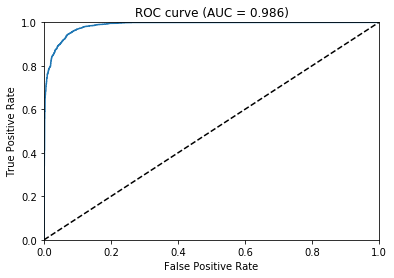

In [14]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [15]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0014616901753470302, recall = 1.0, precision = 0.6403252032520326
Threshold 0.001591381267644465, recall = 0.9994921279837481, precision = 0.6431372549019608
Threshold 0.0016671220073476434, recall = 0.9994921279837481, precision = 0.6463054187192119
Threshold 0.0017494905041530728, recall = 0.9994921279837481, precision = 0.6495049504950495
Threshold 0.001889434177428484, recall = 0.9994921279837481, precision = 0.6527363184079602
Threshold 0.002027014037594199, recall = 0.9994921279837481, precision = 0.656
Threshold 0.0021866143215447664, recall = 0.9994921279837481, precision = 0.6592964824120603
Threshold 0.0023970080073922873, recall = 0.9994921279837481, precision = 0.6626262626262627
Threshold 0.0025779500138014555, recall = 0.9994921279837481, precision = 0.665989847715736
Threshold 0.002748786471784115, recall = 0.9994921279837481, precision = 0.6693877551020408
Threshold 0.002949698828160763, recall = 0.9994921279837481, precision = 0.6728205128205128
Threshold 0

AUC Score (Test): 0.978125


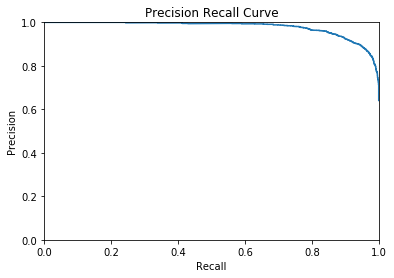

In [16]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9994072  0.9999572  0.08930802 0.9998258  0.99991584]
1969 3031
[2.39e+03 8.80e+01 4.50e+01 3.40e+01 2.20e+01 2.70e+01 1.60e+01 2.10e+01
 1.90e+01 1.50e+01 1.60e+01 1.50e+01 6.00e+00 1.30e+01 1.00e+01 2.00e+00
 4.00e+00 7.00e+00 8.00e+00 4.00e+00 3.00e+00 6.00e+00 7.00e+00 4.00e+00
 6.00e+00 4.00e+00 1.10e+01 5.00e+00 7.00e+00 5.00e+00 3.00e+00 5.00e+00
 3.00e+00 6.00e+00 5.00e+00 7.00e+00 6.00e+00 8.00e+00 6.00e+00 5.00e+00
 7.00e+00 8.00e+00 1.20e+01 1.20e+01 1.00e+01 1.60e+01 1.70e+01 1.40e+01
 2.50e+01 3.60e+01]
[   8    7    3    5    6    1    3    3    2    6    6    4    3    3
    3    2    5    2    2    2    3    2    5    3    5    2    6    2
    4    4    7    4    7    8    9    6    5   11    2    9    9   10
   10   18   17   31   28   56   90 1040]


(0, 350)

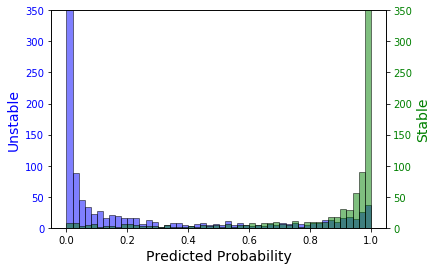

In [17]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

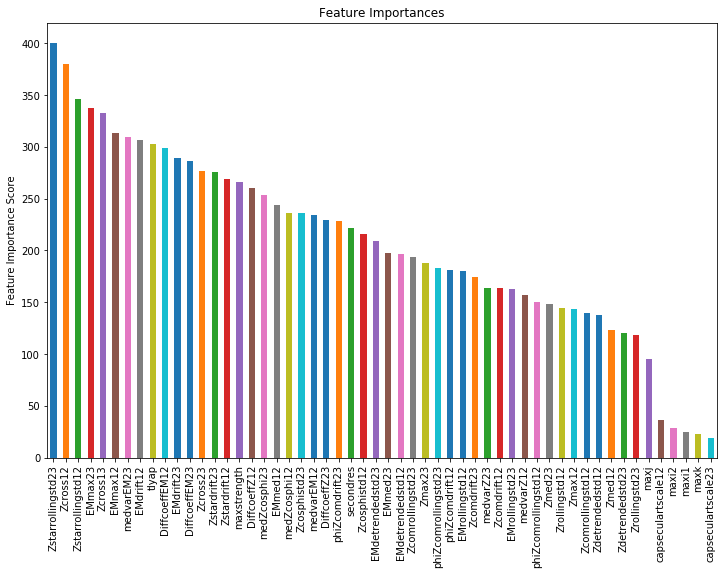

In [18]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/ressummaryfeaturesxgb_random.pkl", "wb"))